# Evaluate and submit predictions

### Imports

In [1]:
import os
if 'notebooks' in os.getcwd(): os.chdir('../..')  # change to main directory
print('Working directory:', os.getcwd() )

Working directory: /scratch/snx3000/bp000429/submission/adrian_sensorium


In [2]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from nnfabrik.builder import get_data, get_model, get_trainer

from sensorium.utility import submission
from sensorium.utility.training import read_config

### Load configuration for model

In [3]:
config_file = 'notebooks/submission_m3/config_submission_m3.yaml'
config = read_config( config_file )
print(config)

ordereddict([('data_sets', ['all']), ('dataset_fn', 'sensorium.datasets.static_loaders'), ('dataset_config', ordereddict([('normalize', True), ('include_behavior', True), ('include_eye_position', True), ('batch_size', 128), ('scale', 0.25), ('preload_from_merged_data', True), ('include_trial_id', True), ('include_rank_id', True), ('include_history', True), ('include_behav_state', True), ('adjusted_normalization', True)])), ('model_fn', 'sensorium.models.modulated_stacked_core_full_gauss_readout'), ('model_seed', 3452), ('model_config', ordereddict([('pad_input', False), ('stack', -1), ('layers', 4), ('input_kern', 9), ('gamma_input', 9.8), ('gamma_readout', 0.48), ('hidden_kern', 10), ('hidden_channels', 64), ('depth_separable', True), ('grid_mean_predictor', ordereddict([('type', 'cortex'), ('input_dimensions', 2), ('hidden_layers', 4), ('hidden_features', 20), ('nonlinearity', 'ReLU'), ('final_tanh', True)])), ('init_sigma', 0.14), ('init_mu_range', 0.8), ('gauss_type', 'full'), ('sh

### Prepare dataloader

In [4]:
if config['data_sets'][0] == 'all':
    basepath = "notebooks/data/"
    filenames = [os.path.join(basepath, file) for file in os.listdir(basepath) if ".zip" in file ]
    filenames = [file for file in filenames if 'static26872-17-20' not in file]
else:
    filenames = config['data_sets']
    # filenames like ['notebooks/data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip', ]
    
dataset_fn = config['dataset_fn']  # 'sensorium.datasets.static_loaders'
dataset_config = {'paths': filenames,
                  **config['dataset_config'],
                 }

dataloaders = get_data(dataset_fn, dataset_config)

### Load saved model

In [5]:
# Instantiate model
model_fn = config['model_fn']     # e.g. 'sensorium.models.modulated_stacked_core_full_gauss_readout'
model_config = config['model_config']

model = get_model(model_fn=model_fn,
                  model_config=model_config,
                  dataloaders=dataloaders,
                  seed=config['model_seed'],
                 )

# Load trained weights
save_file = 'notebooks/submission_m3/results/model_v3.pth'
model.load_state_dict(torch.load(save_file));

### Generate submission file

In [6]:
dataset_name = '27204-5-13'

submission.generate_submission_file(trained_model=model, 
                                    dataloaders=dataloaders,
                                    data_key=dataset_name,
                                    path="notebooks/submission_m3/results/",
                                    device="cuda")

Submission file saved for tier: live_test. Saved in: notebooks/submission_m3/results/submission_file_live_test.csv
Submission file saved for tier: final_test. Saved in: notebooks/submission_m3/results/submission_file_final_test.csv


### Evaluate model on all datasets

In [7]:
from sensorium.utility import get_correlations, get_signal_correlations, get_fev
from sensorium.utility.measure_helpers import get_df_for_scores

#### Test data

In [8]:
single_trial_correlation = get_correlations(model, dataloaders, tier="test", device="cuda", as_dict=True)

df = get_df_for_scores(session_dict=single_trial_correlation,
                                    measure_attribute="Single Trial Correlation"
                      )

In [9]:
%matplotlib inline

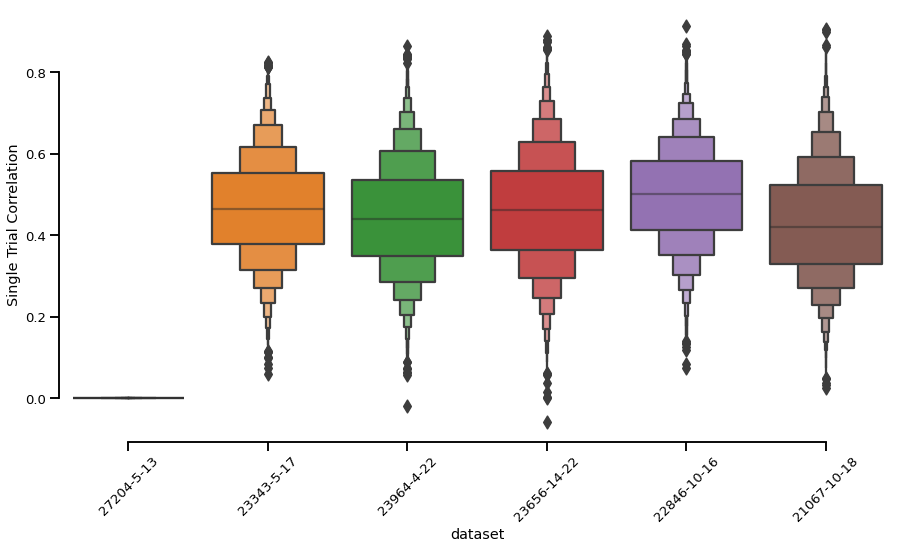

In [10]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15,8))
sns.boxenplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.xticks(rotation = 45);
sns.despine(trim=True)

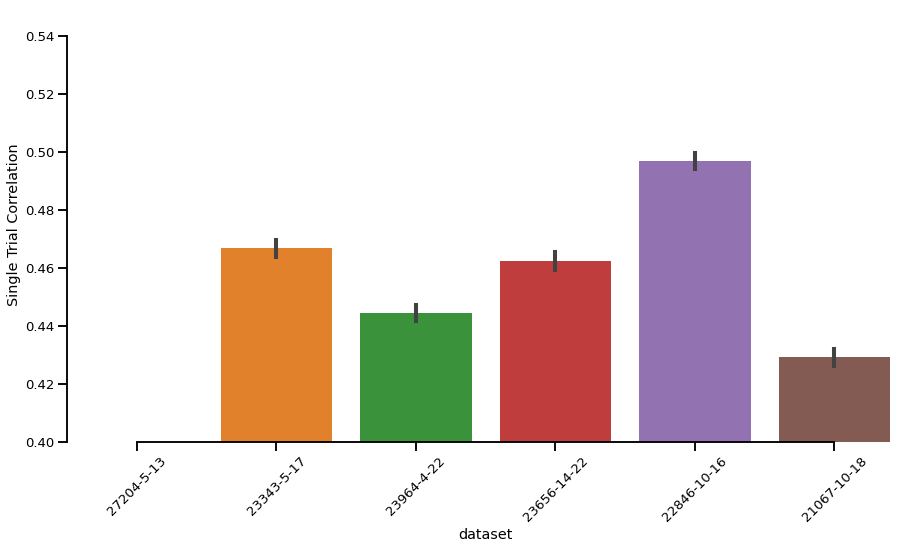

In [11]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15,8))
sns.barplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.xticks(rotation = 45);
plt.ylim(0.4,0.55)
sns.despine(trim=True)

In [12]:
df.groupby('dataset').describe()

Single Trial Correlation                                          \
                               count      mean       std       min       25%   
dataset                                                                        
21067-10-18                   8372.0  0.429321  0.137074  0.024569  0.330782   
22846-10-16                   7344.0  0.496691  0.123146  0.074687  0.412349   
23343-5-17                    7334.0  0.466843  0.127767  0.060652  0.379161   
23656-14-22                   8107.0  0.462156  0.141216 -0.057434  0.363589   
23964-4-22                    8098.0  0.444392  0.134663 -0.019587  0.349375   
27204-5-13                    7538.0  0.000000  0.000000  0.000000  0.000000   

                                           
                  50%       75%       max  
dataset                                    
21067-10-18  0.419236  0.523593  0.904860  
22846-10-16  0.500109  0.582341  0.912250  
23343-5-17   0.464756  0.553841  0.824300  
23656-14-22  0.461285  0.558322  0.889522  
23964-4-22   0.440668  0.536183  0.865004  
27204-5-13   0.000000  0.000000  0.000000

#### Validation data

In [13]:
single_trial_correlation = get_correlations(model, dataloaders, tier="validation", device="cuda", as_dict=True)

df = get_df_for_scores(session_dict=single_trial_correlation,
                                    measure_attribute="Single Trial Correlation"
                      )

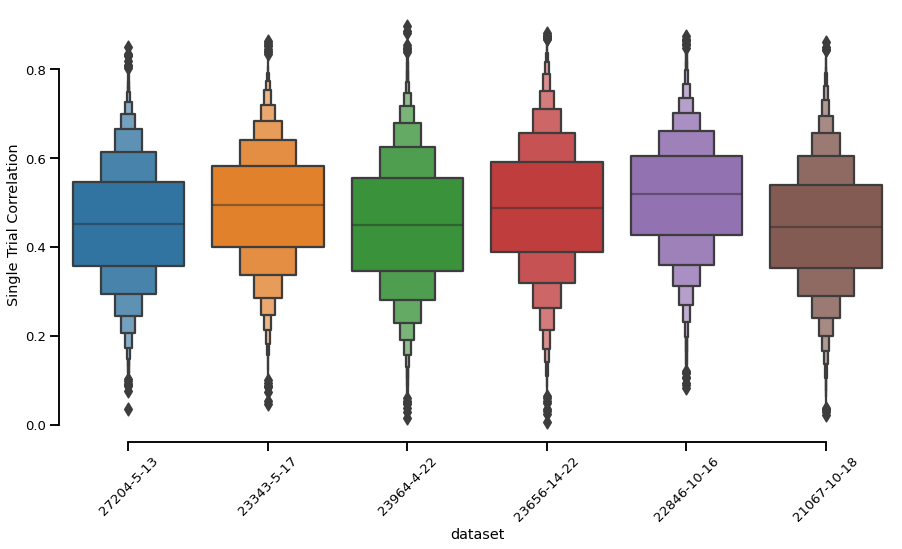

In [14]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15,8))
sns.boxenplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.xticks(rotation = 45);
sns.despine(trim=True)

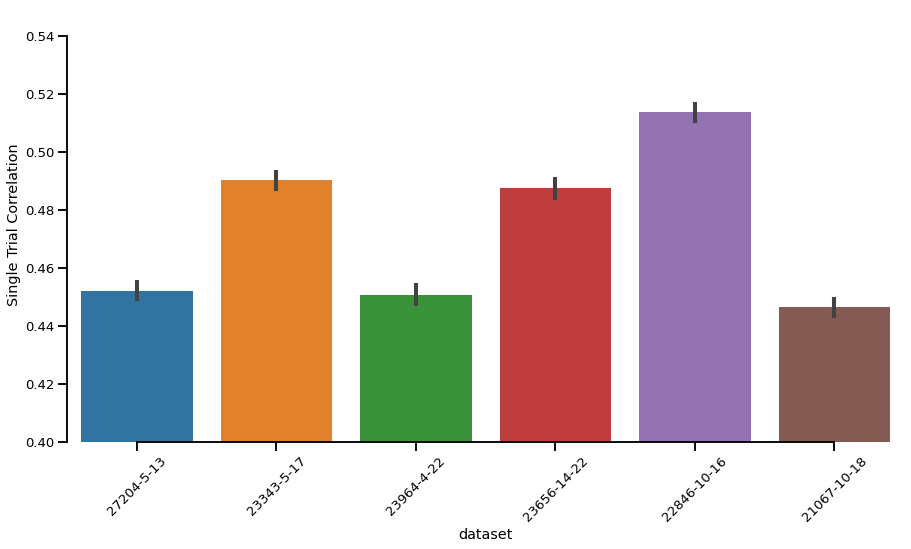

In [15]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15,8))
sns.barplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.xticks(rotation = 45);
plt.ylim(0.4,0.55)
sns.despine(trim=True)

In [16]:
df.groupby('dataset').describe()

Single Trial Correlation                                          \
                               count      mean       std       min       25%   
dataset                                                                        
21067-10-18                   8372.0  0.446383  0.134321  0.021966  0.351585   
22846-10-16                   7344.0  0.513534  0.127403  0.083726  0.426696   
23343-5-17                    7334.0  0.490154  0.128921  0.046514  0.400917   
23656-14-22                   8107.0  0.487460  0.144637  0.006951  0.388051   
23964-4-22                    8098.0  0.450720  0.144784  0.016311  0.345783   
27204-5-13                    7538.0  0.451987  0.133989  0.036307  0.357079   

                                           
                  50%       75%       max  
dataset                                    
21067-10-18  0.445559  0.539803  0.860717  
22846-10-16  0.519254  0.604379  0.873179  
23343-5-17   0.494779  0.582252  0.862013  
23656-14-22  0.488378  0.589975  0.880983  
23964-4-22   0.450073  0.555691  0.895733  
27204-5-13   0.450525  0.546094  0.849640